In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setting Up Environment 

In [ ]:
# Download Tiny ImageNet from CS231n
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip

# Unzip the dataset
!unzip -q tiny-imagenet-200.zip -d /kaggle/working/tiny-imagenet


In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Enable CuDNN benchmarking for faster training
torch.backends.cudnn.benchmark = True

# Define the paths for the dataset
data_dir = '/kaggle/working/tiny-imagenet/tiny-imagenet-200'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Define image transformations for training (augmentation)
train_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define image transformations for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the training and validation data
train_dataset = ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True)

val_dataset = ImageFolder(val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples: 100000
Number of validation samples: 10000


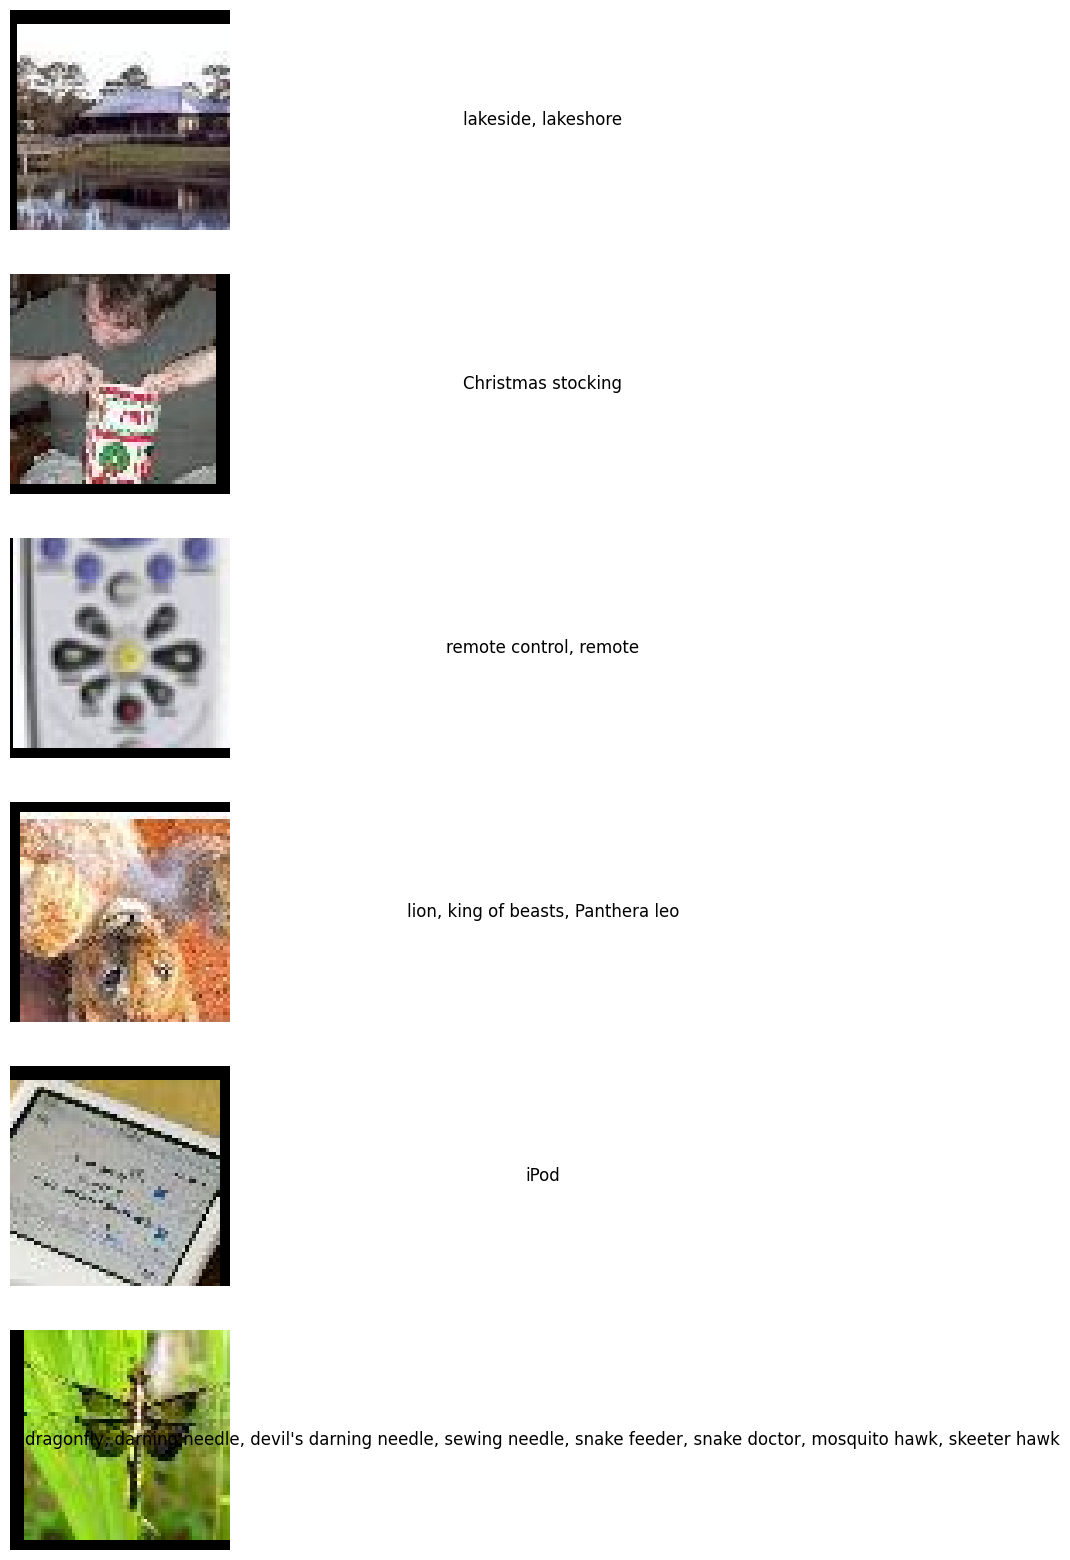

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Load WNID to human-readable label mapping from words.txt
wnid_to_words = {}
with open(os.path.join(data_dir, 'words.txt'), 'r') as f:
    for line in f:
        wnid, word = line.split('\t')
        wnid_to_words[wnid] = word.strip()

# Mapping between label indices and class WNIDs
class_to_idx = train_dataset.class_to_idx  # Class to WNID mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}  # Inverse mapping (index to WNID)

# Function to display a single image and label side by side
def imshow_with_label_side(image, label, ax_image, ax_label):
    """Displays a single image and its label next to it."""
    # Unnormalize the image
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # Undo normalization
    image = np.clip(image, 0, 1)  # Clip to range [0, 1]
    
    # Get WNID and corresponding word label
    wnid = idx_to_class[label.item()]
    human_label = wnid_to_words.get(wnid, "Unknown")  # Get human-readable label

    # Display the image
    ax_image.imshow(image)
    ax_image.axis('off')  # Hide axes for image
    ax_label.text(0.5, 0.5, human_label, fontsize=12, ha='center', va='center')  # Add label text
    ax_label.axis('off')  # Hide axes for label

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Create a vertical layout of 6 images with labels on the side
fig, axes = plt.subplots(6, 2, figsize=(10, 20))  # 6 rows, 2 columns (image, label)

# Display 6 images and their labels side by side
for i in range(6):
    imshow_with_label_side(images[i], labels[i], axes[i, 0], axes[i, 1])

plt.show()


# BASELINE MODEL Fine Tuning and Evaluation

In [3]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from torch.optim import lr_scheduler
from tqdm import tqdm


In [10]:
from torchvision.models import ResNet18_Weights, DenseNet169_Weights, EfficientNet_B0_Weights

# Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of output classes (Tiny ImageNet has 200 classes)
num_classes = 200

# Fine-tuning ResNet18
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(resnet18.fc.in_features, num_classes)  # Replace final FC layer
)
resnet18 = resnet18.to(device)

# Fine-tuning DenseNet169
densenet169 = models.densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)
densenet169.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(densenet169.classifier.in_features, num_classes)  # Replace classifier layer
)
densenet169 = densenet169.to(device)

# Fine-tuning EfficientNet-B0
efficientnet_b0 = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0.classifier[1] = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(efficientnet_b0.classifier[1].in_features, num_classes)
)
efficientnet_b0 = efficientnet_b0.to(device)

# Set up loss function and optimizer (same for all models)
criterion = nn.CrossEntropyLoss()

# Set up optimizers for each model with AdamW optimizer and increased weight decay
optimizer_resnet = torch.optim.AdamW(resnet18.parameters(), lr=0.0005, weight_decay=1e-3)
optimizer_densenet = torch.optim.AdamW(densenet169.parameters(), lr=0.0005, weight_decay=1e-3)
optimizer_efficientnet = torch.optim.AdamW(efficientnet_b0.parameters(), lr=0.0005, weight_decay=1e-3)

# Scheduler for learning rate adjustment with an increased step_size of 10
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.1)
scheduler_densenet = lr_scheduler.StepLR(optimizer_densenet, step_size=10, gamma=0.1)
scheduler_efficientnet = lr_scheduler.StepLR(optimizer_efficientnet, step_size=10, gamma=0.1)

# Check if models are loaded and print confirmation
if resnet18 and densenet169 and efficientnet_b0:
    print("Models imported successfully:")
    print("- ResNet18")
    print("- DenseNet169")
    print("- EfficientNet-B0")
else:
    print("Error loading models.")

Models imported successfully:
- ResNet18
- DenseNet169
- EfficientNet-B0


In [11]:
from torch.optim import lr_scheduler
from tqdm import tqdm

# CuDNN benchmarking
torch.backends.cudnn.benchmark = True

# Image transformations with enhanced data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataloaders with batch_size adjustment
train_loader = DataLoader(ImageFolder(train_dir, transform=train_transform), batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(ImageFolder(val_dir, transform=val_transform), batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training loop with early stopping and model name display
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    early_stopping = EarlyStopping(patience=3)
    
    print(f"Training {model_name}...\n")
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs} for {model_name}')
        print('-' * 10)

        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print(f'{model_name} - Training Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'{model_name} - Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered for {model_name}")
            break

        # Scheduler step
        scheduler.step()

# Train all models in parallel
train_model(resnet18, "ResNet18", train_loader, val_loader, criterion, optimizer_resnet, scheduler_resnet, num_epochs=20, device=device)
train_model(densenet169, "DenseNet169", train_loader, val_loader, criterion, optimizer_densenet, scheduler_densenet, num_epochs=20, device=device)
train_model(efficientnet_b0, "EfficientNet-B0", train_loader, val_loader, criterion, optimizer_efficientnet, scheduler_efficientnet, num_epochs=20, device=device)

Training ResNet18...

Epoch 1/20 for ResNet18
----------


100%|██████████| 3125/3125 [01:28<00:00, 35.17it/s]


ResNet18 - Training Loss: 4.3011 Acc: 0.1056
ResNet18 - Validation Loss: 8.4372 Acc: 0.0068
Epoch 2/20 for ResNet18
----------


100%|██████████| 3125/3125 [01:29<00:00, 35.05it/s]


ResNet18 - Training Loss: 3.5154 Acc: 0.2108
ResNet18 - Validation Loss: 9.2510 Acc: 0.0055
Epoch 3/20 for ResNet18
----------


 13%|█▎        | 408/3125 [00:12<01:20, 33.70it/s]


KeyboardInterrupt: 